In [ ]:
import tensorflow as tf
from architecture.architecture_vgg16 import SSD
from datasets.face_dataset.face_dataset import CLASS_DICT
import tensorflow_datasets as tfds
from anchor import multibox_detection
import numpy as np
import os
import shutil
from utils import show_bboxes
from d2l import tensorflow as d2l
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def predict(net, X, confidence=0.5, iou_threshold=0.5):
    anchors, cls_preds, bbox_preds = net(X)
    cls_probs = tf.exp(cls_preds)/ tf.reduce_sum(tf.exp(cls_preds), axis=2, keepdims=True)
    output = multibox_detection(tf.transpose(cls_probs, perm=[0,2,1]), bbox_preds, anchors, iou_threshold)
    indices = tf.squeeze(tf.where(output[0][:,0] != -1),[1])
    output = tf.gather(output[0], indices)
    output = tf.gather(output, tf.squeeze(tf.where(output[:,1] >= confidence),[1]))
    return output

def save_txt_file(pred_path, pred, label_path=None, label=None):
    with open(pred_path, 'w') as f:
        for box in pred:
            f.write(f'{int(box[0])} {box[1]} {box[2]} {box[3]} {box[4]} {box[5]}\n')
        f.close()
    if label_path is not None and label is not None:
        with open(label_path, 'w') as f:
            for box in label:
                f.write(f'{int(box[0])} {box[1]} {box[2]} {box[3]} {box[4]}\n')
            f.close()

if __name__ == "__main__":

    strategy = tf.distribute.MirroredStrategy()
    model_path = '/dl/ssd/trained_models/ssd_vgg16/best_model/'
    dataset = tfds.load("face_dataset")

    with strategy.scope():
        net = SSD(num_classes=len(CLASS_DICT.keys()))

    if model_path is not None:
        net = tf.keras.models.load_model(model_path)

In [7]:
import matplotlib
matplotlib.use('Agg')
plt.ioff()

KeyboardInterrupt: 

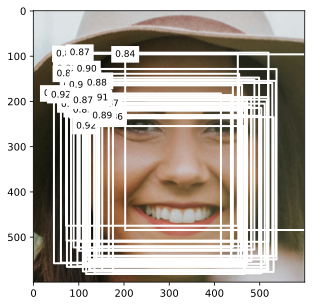

In [16]:

def display(img, output, save_path=None):
    d2l.set_figsize((5,5))
    fig = d2l.plt.imshow(img.astype(np.uint8))
    for row in output:
        score = float(row[1])
        show_bboxes(fig.axes, [row[2:6]], '%.2f' % score, 'w')
    if save_path is not None:
        d2l.plt.savefig(save_path)

confidence = 0.8
iou_threshold = 0.1
im_size = (300,300)
num_imshow = 300
test_dataset = dataset['valid']
pred_folder_path = './predicted_images'
for i,e in enumerate(test_dataset):
    if i == num_imshow:
        break
    # print(e['image_filename'])
    normalized_box = predict(net, tf.expand_dims(tf.image.resize(e['image'],im_size),0), confidence, iou_threshold)
    width, height = e['size'][1], e['size'][0]
    a = normalized_box[:,:2]
    b = normalized_box[:,2:] * tf.expand_dims(tf.convert_to_tensor((width,height,width,height),dtype=tf.float32),0)
    pred = tf.concat((a,b),axis=1)
    label = e['objects']
    a = label[:,:1] 
    b = label[:,1:]* tf.expand_dims(tf.convert_to_tensor((width,height,width,height),dtype=tf.float32),0)
    gt = tf.concat((a,b),axis=1)
    pred_path = os.path.join(pred_folder_path, os.path.splitext(e['image_filename'].numpy().decode('UTF-8'))[0] + '.png')
    display(e['image'].numpy(), pred, pred_path)